In [ ]:
!pip -q install diffusers transformers accelerate torch xformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.7 MB/s eta 0:00:00


In [ ]:
!pip install qrcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

In [ ]:
import qrcode
qrcode_generator = qrcode.QRCode(
    version=1,
    error_correction=qrcode.ERROR_CORRECT_H,
    box_size=10,
    border=4,
)


In [ ]:
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img


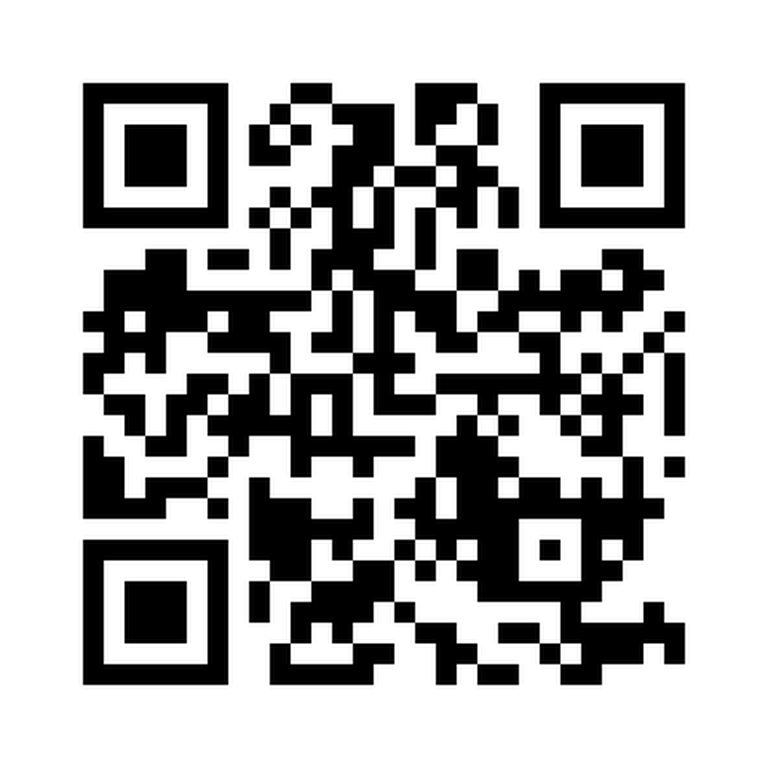

In [ ]:
qr_code_content = "https://www.launchpad.ai"
qr = qrcode.QRCode(
            version=1,
            error_correction=qrcode.constants.ERROR_CORRECT_H,
            box_size=10,
            border=4,
)
qr.add_data(qr_code_content)
qr.make(fit=True)
qrcode_image = qr.make_image(fill_color="black", back_color="white")
qrcode_image = resize_for_condition_image(qrcode_image, 768)
qrcode_image

In [ ]:


controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v11p_sd21",
                                             torch_dtype=torch.float16)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()



# play with guidance_scale, controlnet_conditioning_scale and strength to make a valid QR Code Image

# qr code image
source_image = qrcode_image
# initial image, anything
init_image = load_image("https://s3.amazonaws.com/moonup/production/uploads/noauth/KfMBABpOwIuNolv1pe3qX.jpeg")
condition_image = resize_for_condition_image(source_image, 768)
init_image = resize_for_condition_image(init_image, 768)
generator = torch.manual_seed(123121231)
image = pipe(prompt="a bilboard in NYC with a qrcode",
             negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
             image=init_image,
             control_image=condition_image,
             width=768,
             height=768,
             guidance_scale=20,
             controlnet_conditioning_scale=1.5,
             generator=generator,
             strength=0.9,
             num_inference_steps=150,
            )

image.images[0]
